In [1]:
import pandas as pd
import numpy as np
from ete3 import Tree
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import matplotlib.pyplot as plt

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [32]:
do_weighted = False

relevant_features = ["partner.diversity", # shanon diversity
                     "d", # speciality index d',
                     "normalised.degree",
                     "weighted.betweenness", # centrality,
                     "weighted.closeness",
                     "hubbiness_score"]  # generality
relevant_features += [f"standardized_{f}" for f in relevant_features]
relevant_metadata = [] 
#                      ['taxonomic_rank', 
#                      'cot', 
#                      'growth', 
#                      'life_form', 
#                      'si', 
#                      'pollination_mode', 
#                      'selfing_mode',
#                      'mean_tm']

allmb_tree_path = "../../../data/trees/ALLMB.tre"
networks_dir = "../../../data/networks/all/"
species_features_paths = {"binary": "../../../data/features/plant/binary/features.csv",
                          "binarized_weighted": "../../../data/features/plant/binarized_weighted/features.csv",
                          "weighted": "../../../data/features/plant/weighted/features.csv"}
classification_path = "../../../data/ploidy_classification/plant_classification.csv"
ploidb_path = "../../../data/ploidy_classification/ploidb_by_genus_without_missing.csv"

processed_data_path = f"../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"
pre_processed_tree_path = f"../../../data/statistical_analysis/species_level/unique_species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
processed_tree_path = f"../../../data/statistical_analysis/species_level/species_tree_on_{'un' if not do_weighted else ''}weighted_networks.nwk"
species_list_path = f"../../../data/statistical_analysis/species_level/species_list_{'un' if not do_weighted else ''}weighted_analysis.csv"

# process data

In [3]:
allmb_tree = Tree(allmb_tree_path, format=1)
for leaf in allmb_tree.get_leaves():
    leaf.name = leaf.name.lower().replace("_", " ")

In [4]:
relevant_columns = ["Plant", "network"] + relevant_features + relevant_metadata
weighted_data = pd.read_csv(species_features_paths["weighted"])[relevant_columns]
weighted_data["network_type"] = "weighted"
binarized_weighted_data = pd.read_csv(species_features_paths["binarized_weighted"])[relevant_columns]
binarized_weighted_data["network_type"] = "binarized_weighted"
binary_data = pd.read_csv(species_features_paths["binary"])[relevant_columns]
binary_data["network_type"] = "binary"               
features = pd.concat([weighted_data,binarized_weighted_data,binary_data])
features.network = features.network.str.replace(".csv", "").astype(int)
features["original_name"] = features.Plant.str.lower()

/tmp/ipykernel_15732/1531322667.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  features.network = features.network.str.replace(".csv", "").astype(int)


In [5]:
classification = pd.read_csv(classification_path).rename(columns={"conservative_is_polyploid_by_resolved": "is_polyploid"})

In [6]:
features_with_classification = features.merge(classification[["original_name", "resolved_name", "is_polyploid"]], on="original_name", how="left")
features_with_classification.set_index("original_name", inplace=True)
features_with_classification["is_polyploid"].fillna(classification.set_index("original_name")["conservative_is_polyploid_by_original"].to_dict(), inplace=True)
features_with_classification.reset_index(inplace=True)

In [7]:
features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / features_with_classification.shape[0]*100

is_polyploid
0.0    24.879652
1.0    20.070357
NaN    55.049991
Name: original_name, dtype: float64

In [8]:
clean_features_with_classification = features_with_classification.dropna(subset=relevant_features+["is_polyploid"], how="any", axis=0)

In [9]:
clean_features_with_classification.groupby("is_polyploid", dropna=False)["original_name"].count() / clean_features_with_classification.shape[0]*100

is_polyploid
0.0    55.401911
1.0    44.598089
Name: original_name, dtype: float64

In [10]:
print(f"# species from networks = {len(clean_features_with_classification.original_name.unique()):,}")
print(f"# species in tree = {len(allmb_tree.get_leaf_names()):,}")

# species from networks = 1,468
# species in tree = 356,305


## add network size data

In [11]:
if do_weighted:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type == "weighted"]
else:
    clean_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.network_type != "weighted"]

In [12]:
def get_network_size(net_path):
    try:
        net = pd.read_csv(net_path).set_index("Plant")
        num_plants = net.shape[0]
        num_pollinators = net.shape[1]
        return num_plants, num_pollinators
    except:
        return np.nan, np.nan

network_to_size = clean_features_with_classification[["network_type", "network"]].drop_duplicates()
network_to_size[["num_network_plants", "num_network_pollinators"]] = network_to_size.parallel_apply(lambda record: get_network_size(f"{networks_dir}{record.network_type}/{record.network}.csv"), axis=1, result_type="expand") 
    
clean_features_with_classification = clean_features_with_classification.merge(network_to_size, on=["network_type", "network"], how="left")

In [13]:
tree_names = set(allmb_tree.get_leaf_names())
final_features_with_classification = clean_features_with_classification.loc[clean_features_with_classification.original_name.isin(tree_names) |
                                                                            clean_features_with_classification.resolved_name.isin(tree_names)]
final_features_with_classification["mapped_name"] = final_features_with_classification.apply(lambda record: record.original_name if record.original_name in tree_names else record.resolved_name, axis=1)
print(f"# species from networks for analysis = {len(final_features_with_classification.mapped_name.unique()):}")

# species from networks for analysis = 1066


/tmp/ipykernel_15732/4156360445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["mapped_name"] = final_features_with_classification.apply(lambda record: record.original_name if record.original_name in tree_names else record.resolved_name, axis=1)


In [14]:
pruned_allmb_tree = allmb_tree.copy()
pruned_allmb_tree.prune(final_features_with_classification.mapped_name.unique().tolist(), preserve_branch_length=True)
print(f"# species in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# species in tree = 1,066


In [15]:
final_features_with_classification["mapped_name"] = final_features_with_classification["mapped_name"].str.replace(" ", "_")
final_features_with_classification["sample_id"] = final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network"].astype("str")

/tmp/ipykernel_15732/4258440952.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["mapped_name"] = final_features_with_classification["mapped_name"].str.replace(" ", "_")
/tmp/ipykernel_15732/4258440952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification["sample_id"] = final_features_with_classification["mapped_name"] + "_" + final_features_with_classification["network_type"] + "_" + final_features_with_classification["network"].astype(

In [16]:
final_features_with_classification.sample_id = final_features_with_classification.sample_id.str.replace(" ", "_")
for l in pruned_allmb_tree.get_leaves():
    l.name = l.name.replace(" ", "_")

/tmp/ipykernel_15732/1547168379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification.sample_id = final_features_with_classification.sample_id.str.replace(" ", "_")


In [17]:
pruned_allmb_tree.write(outfile=pre_processed_tree_path, format=5)

In [18]:
final_features_with_classification = final_features_with_classification.drop_duplicates("sample_id")

In [19]:
assert(len(final_features_with_classification.sample_id.unique().tolist()) == final_features_with_classification.shape[0])

In [20]:
# add bushes under each leaf
num_added_nodes =0
tree_leaves = pruned_allmb_tree.get_leaves()
for leaf in tree_leaves:
    children_names = final_features_with_classification.query(f"mapped_name == '{leaf.name}'").sample_id.tolist()
    if len(children_names) > 0:
        for child_name in children_names:
            leaf.add_child(name=child_name, dist=0.00001)
        num_added_nodes += len(children_names)
    else:
        print(f"no child for leaf {leaf.name}")
        leaf.dist = leaf.dist + 0
    
print(f"# added nodes = {num_added_nodes:,}")

# added nodes = 3,717


In [21]:
pruned_allmb_tree.prune(final_features_with_classification.sample_id.dropna().unique().tolist(), preserve_branch_length=True)
final_features_with_classification = final_features_with_classification.loc[final_features_with_classification.sample_id.isin(pruned_allmb_tree.get_leaf_names())]

In [22]:
print(f"# samples in data = {final_features_with_classification.shape[0]:,}")
print(f"# leaves in tree = {len(pruned_allmb_tree.get_leaf_names()):,}")

# samples in data = 3,717
# leaves in tree = 3,717


In [23]:
final_features_with_classification["network_id"] = final_features_with_classification.network_type.astype(str) + "_" + final_features_with_classification.network.astype(str)

In [24]:
print(f"%non-missing data: ")
final_features_with_classification.notna().sum() / final_features_with_classification.shape[0] * 100

%non-missing data: 


original_name                        100.000000
Plant                                100.000000
network                              100.000000
partner.diversity                    100.000000
d                                    100.000000
normalised.degree                    100.000000
weighted.betweenness                 100.000000
weighted.closeness                   100.000000
hubbiness_score                      100.000000
standardized_partner.diversity       100.000000
standardized_d                       100.000000
standardized_normalised.degree       100.000000
standardized_weighted.betweenness    100.000000
standardized_weighted.closeness      100.000000
standardized_hubbiness_score         100.000000
network_type                         100.000000
resolved_name                         98.735539
is_polyploid                         100.000000
num_network_plants                   100.000000
num_network_pollinators              100.000000
mapped_name                          100

In [25]:
final_features_with_classification[relevant_metadata].fillna(-1, inplace=True) # special value for imssing data

/tmp/ipykernel_15732/1049497940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_features_with_classification[relevant_metadata].fillna(-1, inplace=True) # special value for imssing data


In [26]:
final_features_with_classification.to_csv(processed_data_path)
pruned_allmb_tree.write(outfile=processed_tree_path)

In [27]:
species = final_features_with_classification.mapped_name.str.replace("_"," ").unique()
pd.Series(species).to_csv(species_list_path)

In [33]:
final_features_with_classification = pd.read_csv(processed_data_path)

In [34]:
final_features_with_classification.is_polyploid = final_features_with_classification.is_polyploid.replace({1.0: "Polyploids", 0.0: "Diploids"})
features_by_ploidy = final_features_with_classification.groupby("is_polyploid")

/tmp/ipykernel_15732/3270915152.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)


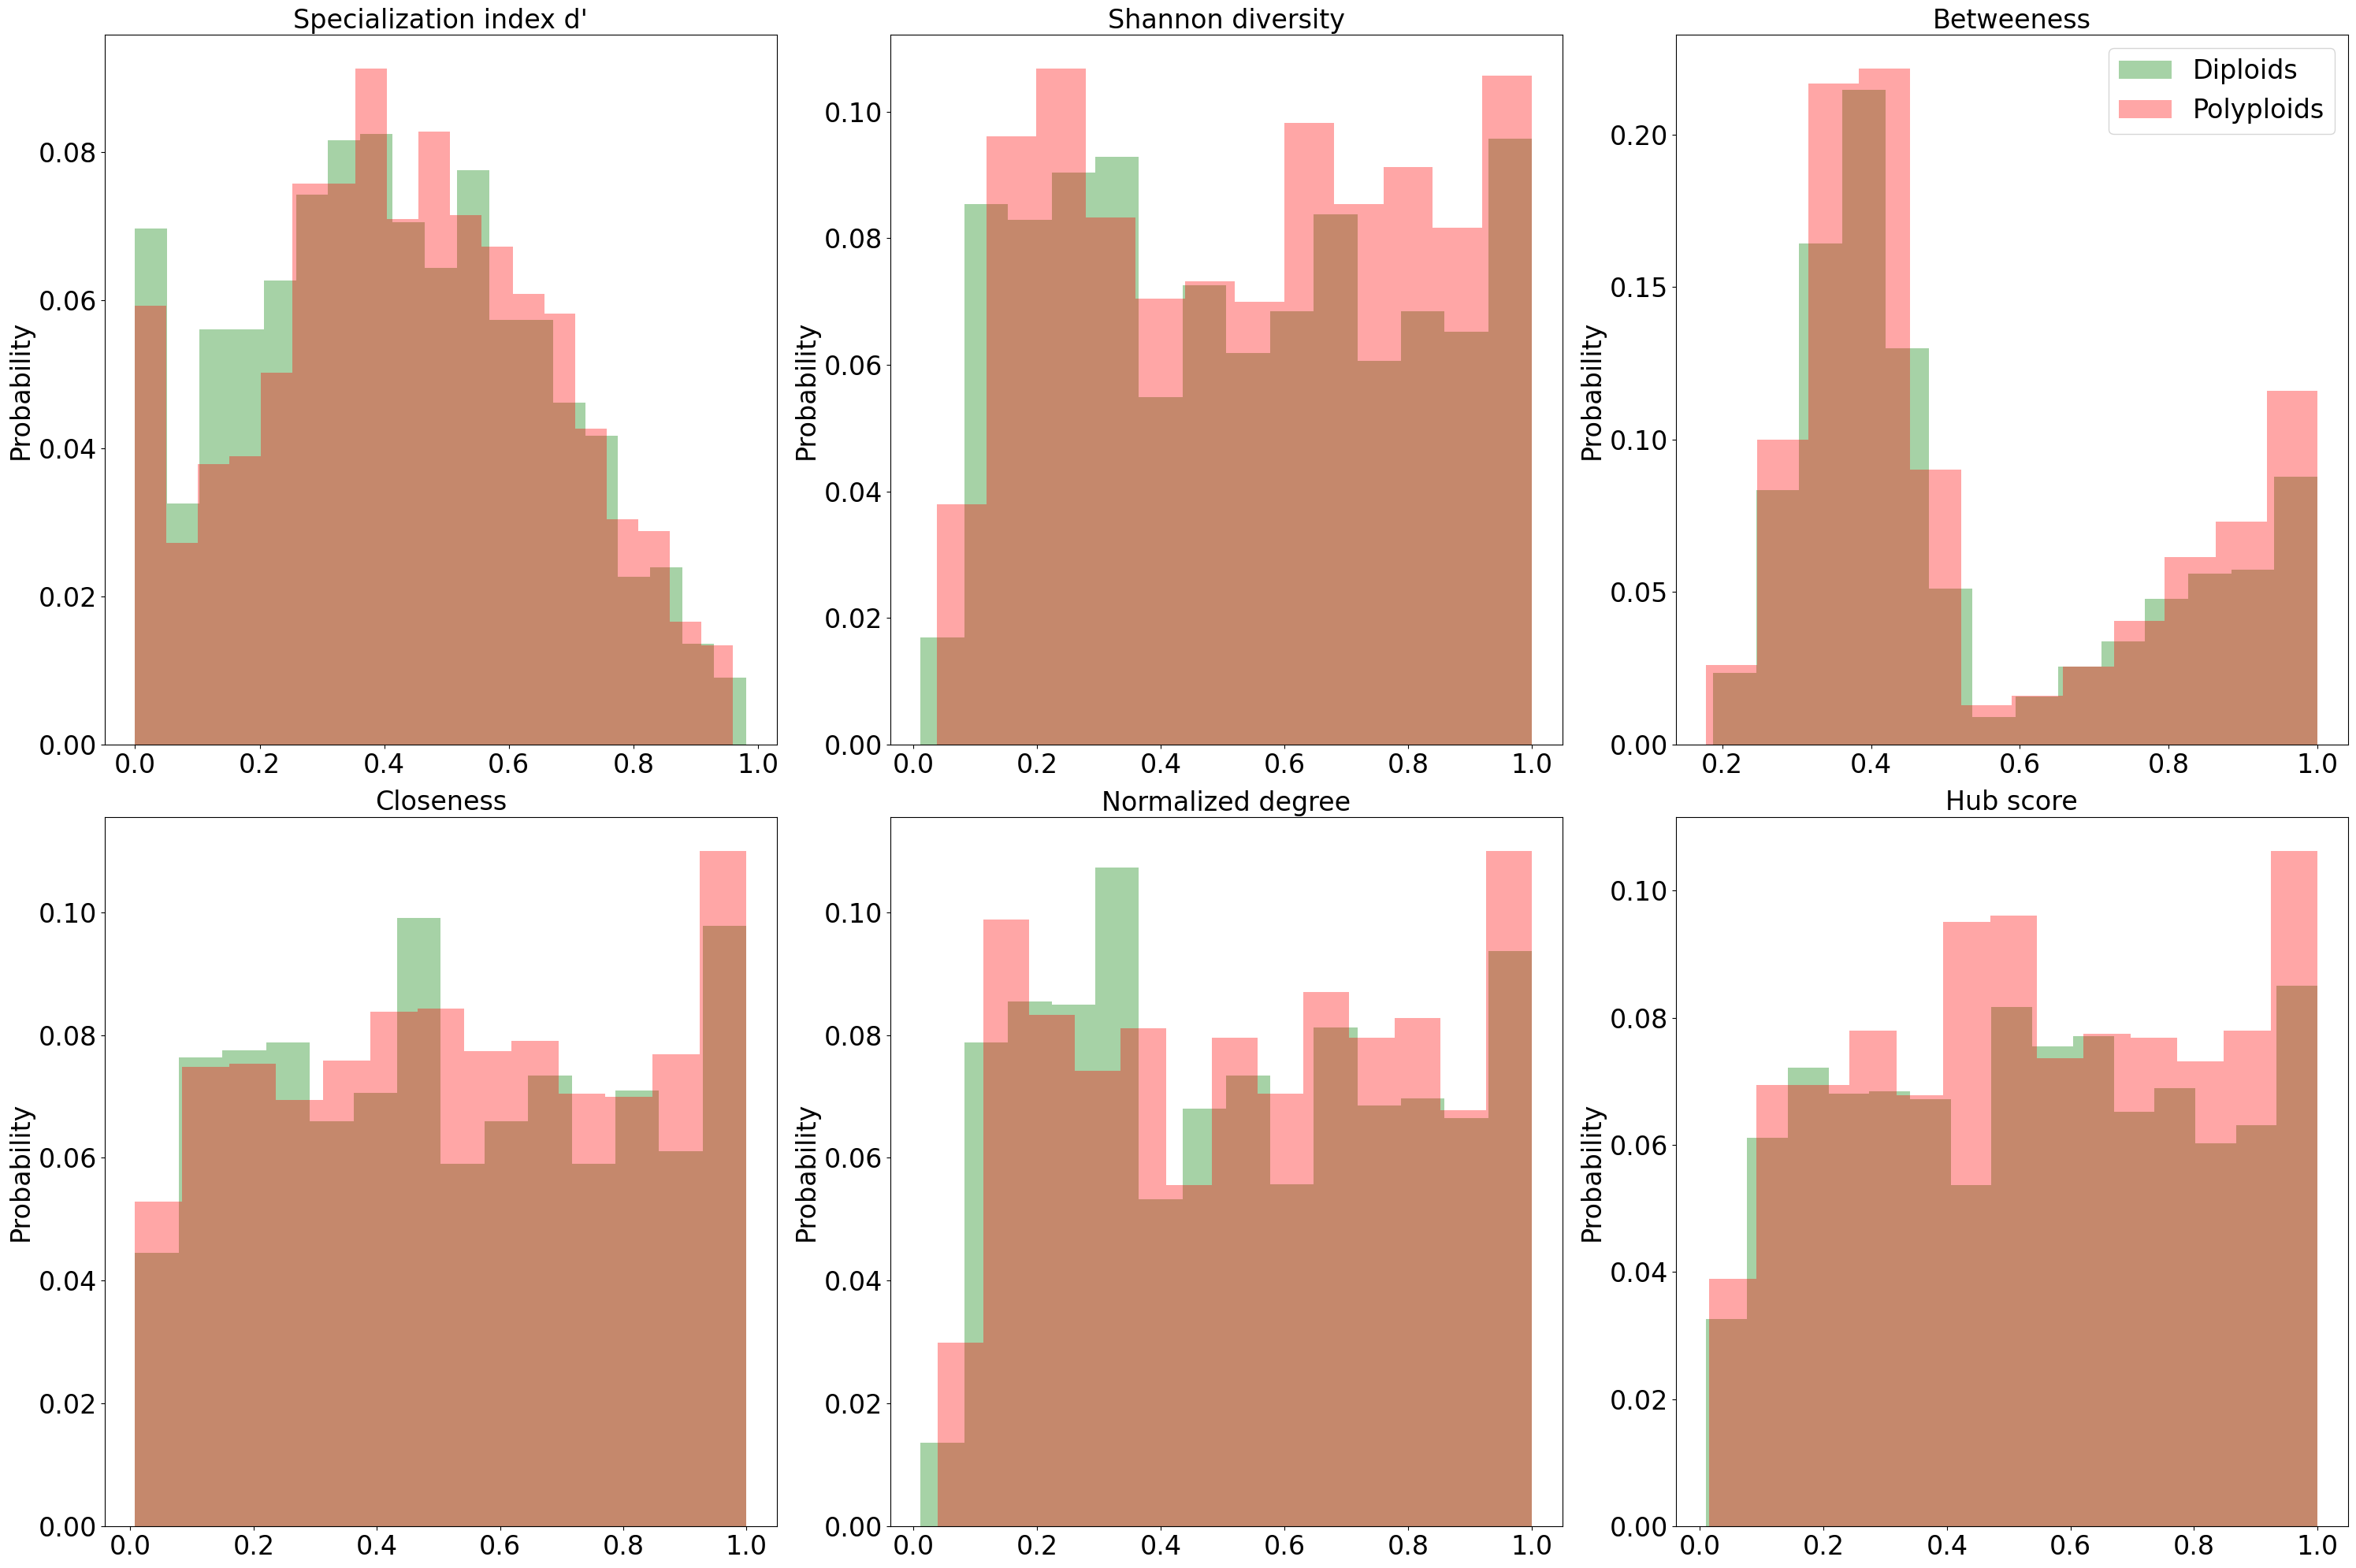

In [35]:
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 24

fig, ax = plt.subplots(figsize=(3*10, 2*10))
# fig.suptitle(f"Indices distribution across {features_by_ploidy.get_group('Polyploids').shape[0]:,} polyploids and {features_by_ploidy.get_group('Diploids').shape[0]:,} diploids", fontsize=fontsize)

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=fig)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=fig)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=fig)
ax4 = plt.subplot2grid((2,6), (1,0), colspan=2, fig=fig)
ax5 = plt.subplot2grid((2,6), (1,2), colspan=2, fig=fig)
ax6 = plt.subplot2grid((2,6), (1,4), colspan=2, fig=fig)

sns.histplot(features_by_ploidy.get_group("Diploids")["d"], label="Diploids", color="green", ax=ax1, stat="probability", alpha=0.35, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["d"], label="Polyploids", ax=ax1, color="red", stat="probability", alpha=0.35, linewidth=0)
ax1.set_title("Specialization index d'", fontsize=fontsize)
ax1.set_xlabel("")
ax1.set_ylabel("Probability", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_partner.diversity"], label="Diploids", color="green", ax=ax2, stat="probability", alpha=0.35, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_partner.diversity"], label="Polyploids", ax=ax2, color="red", stat="probability",alpha=0.35, linewidth=0)
ax2.set_title("Shannon diversity", fontsize=fontsize)
ax2.set_xlabel("")
ax2.set_ylabel("Probability", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.betweenness"], label="Diploids", color="green", ax=ax3, stat="probability", alpha=0.35, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.betweenness"], label="Polyploids", ax=ax3, color="red", stat="probability", alpha=0.35, linewidth=0)
ax3.set_title("Betweeness", fontsize=fontsize)
ax3.legend(prop={'size': fontsize})
ax3.set_xlabel("")
ax3.set_ylabel("Probability", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_weighted.closeness"], label="Diploids", color="green", ax=ax4, stat="probability", alpha=0.35, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_weighted.closeness"], label="Polyploids", ax=ax4, color="red", stat="probability", alpha=0.35, linewidth=0)
ax4.set_title("Closeness", fontsize=fontsize)
ax4.set_xlabel("")
ax4.set_ylabel("Probability", fontsize=fontsize)
ax4.tick_params(axis='both', which='major', labelsize=fontsize)
ax4.tick_params(axis='both', which='minor', labelsize=fontsize)

sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_normalised.degree"], label="Diploids", color="green", ax=ax5, stat="probability", alpha=0.35, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_normalised.degree"], label="Polyploids", ax=ax5, color="red", stat="probability", alpha=0.35, linewidth=0)
ax5.set_title("Normalized degree", fontsize=fontsize)
ax5.set_xlabel("")
ax5.set_ylabel("Probability", fontsize=fontsize)
ax5.tick_params(axis='both', which='major', labelsize=fontsize)
ax5.tick_params(axis='both', which='minor', labelsize=fontsize)


sns.histplot(features_by_ploidy.get_group("Diploids")["standardized_hubbiness_score"], label="Diploids", color="green", ax=ax6, stat="probability", alpha=0.35, linewidth=0)
sns.histplot(features_by_ploidy.get_group("Polyploids")["standardized_hubbiness_score"], label="Polyploids", ax=ax6, color="red", stat="probability", alpha=0.35, linewidth=0)
ax6.set_title("Hub score", fontsize=fontsize)
ax6.set_xlabel("")
ax6.set_ylabel("Probability", fontsize=fontsize)
ax6.tick_params(axis='both', which='major', labelsize=fontsize)
ax6.tick_params(axis='both', which='minor', labelsize=fontsize)

fig.tight_layout()
fig.savefig(f"../../../data/figures/fig2_{'weighted' if do_weighted else 'binary'}.jpeg")